In [1]:
from pyopenms import *
import matplotlib.pyplot as plt

In [2]:
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("Fusion_180220_10.mzML", "Scerevisiae_UPS2_1802.fasta", protein_ids, peptide_ids)

In [3]:
exp = MSExperiment()
MzMLFile().load("Fusion_180220_10.mzML", exp)
filtered = MSExperiment()
for s in exp:
    if s.getMSLevel() == 2:
        filtered.addSpectrum(s)

In [4]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
            obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
            theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
            plt.figure(figsize=(12,8))
            plt.bar(obs_mz, obs_int, width = 3.0)
            plt.bar(theo_mz, theo_int, width = 3.0)
            plt.title(title)
            plt.ylabel('intensity')
            plt.xlabel('m/z')

Peptide scan index: 27
Peptide ID m/z: 557.816467285156
 - Peptide hit rank: 1
 - Peptide hit sequence: LVYQPPIER
 - Peptide hit score: 0.001121256616897881
Number of matched peaks: 9
ion	theo. m/z	observed m/z
y4++	2	LVYQPPIER	257.652826088821	257.18621826171875
y6++	2	LVYQPPIER	370.20849732807096	369.7623291015625
y3+	1	LVYQPPIER	417.245611487571	417.6917724609375
y7++	2	LVYQPPIER	451.740161971621	451.95721435546875
b8++	2	LVYQPPIER	470.76056306732096	470.97259521484375
y8++	2	LVYQPPIER	501.274369115171	501.572998046875
b4+	1	LVYQPPIER	504.281662647071	504.636474609375
y4+	1	LVYQPPIER	514.2983757108709	514.48779296875
y8+	1	LVYQPPIER	1001.541461763571	1001.5343627929688
Peptide scan index: 32
Peptide ID m/z: 588.818420410156
 - Peptide hit rank: 1
 - Peptide hit sequence: YLLNGGSPISR
 - Peptide hit score: 0.0009801281848922372
Number of matched peaks: 7
ion	theo. m/z	observed m/z
b6++	2	YLLNGGSPISR	309.66593365262105	309.422607421875
b9++	2	YLLNGGSPISR	458.250362519471	457.966796875


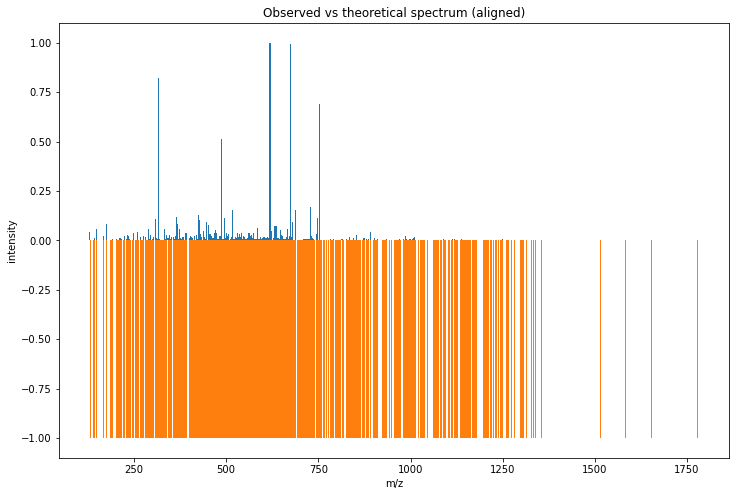

In [6]:
# Peptide identification values
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for peptide_id in peptide_ids[:100]:
    print (35*"=")
    print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print ("Peptide ID m/z:", peptide_id.getMZ())
  # PeptideHits
    for hit in peptide_id.getHits():
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit sequence:", hit.getSequence())
        print(" - Peptide hit score:", hit.getScore())
        
        spectra = filtered.getSpectrum(peptide_id.getMetaValue("scan_index"))
        tsg = TheoreticalSpectrumGenerator()
        thspec = MSSpectrum()
        p = Param()
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        peptide = AASequence.fromString(hit.getSequence().toString())
        tsg.getSpectrum(thspec, peptide, 1, 2)
        
        # Spectrum alignment
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)

        spa.getSpectrumAlignment(alignment, thspec, spectra)

        print("Number of matched peaks: " + str(len(alignment)))
        print("ion\ttheo. m/z\tobserved m/z")
        for theo_idx, obs_idx in alignment:
            ion_name = thspec.getStringDataArrays()[0][theo_idx].decode()
            ion_charge = thspec.getIntegerDataArrays()[0][theo_idx]
            print(ion_name + "\t" + str(ion_charge) + "\t"
                  +peptide.toString()+"\t"+ str(thspec[theo_idx].getMZ())
                  + "\t" + str(spectra[obs_idx].getMZ()))

        
        for theo_idx, obs_idx in alignment:
            theo_mz.append(thspec[theo_idx].getMZ())
            theo_int.append(thspec[theo_idx].getIntensity())
            obs_mz.append(spectra[obs_idx].getMZ())
            obs_int.append(spectra[obs_idx].getIntensity())
title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)